# Introduction

Welcome to my notebook! In this notebook, I explore [**FT-Transformer**](https://arxiv.org/pdf/2106.11959v2.pdf).

FT-Transformer is a Deep NN model using transfomer for tabular data. FT-Transformer is modified from TabTransformer. In FT-Transformer, transformers are used for extracting contextual information from both categorical and numerical data.

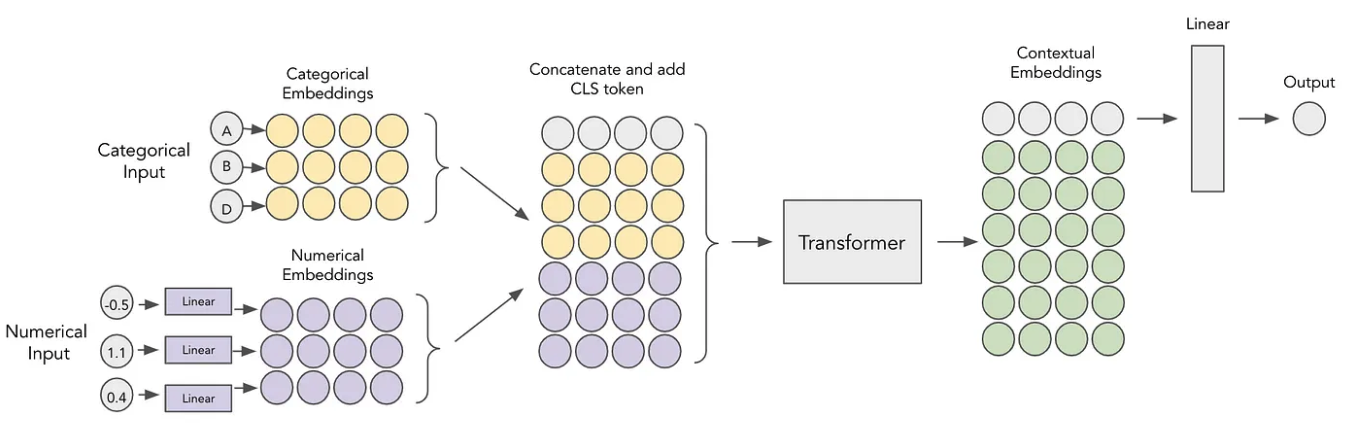
([Image by author](https://arxiv.org/pdf/2106.11959v2.pdf))
I apply FT-Transformer to Gemstone Price Prediction dataset. I use `tabtransfomertf` library to use FTTransformer.

# Import libraries

In [ ]:
!pip install tabtransformertf
!pip install tensorflow-addons
from IPython.display import clear_output
clear_output()

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Read Data

In [ ]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')

In [ ]:
train_df.info()

# Preprocessing

In [ ]:
CATEGORICAL_FEATURES = ['cut', 'color', 'clarity']
NUMERIC_FEATURES = ['carat', 'depth', 'table', 'x', 'y', 'z']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET_FEATURE = 'price'

In [ ]:
sc = StandardScaler()
sc.fit(train_df[NUMERIC_FEATURES])
train_df[NUMERIC_FEATURES]= sc.transform(train_df[NUMERIC_FEATURES])
train_df

In [ ]:
train_data, val_data = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=8)

In [ ]:
# Transform to TF dataset
train_dataset = df_to_dataset(train_data[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=1024)
val_dataset = df_to_dataset(val_data[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=1024)

In [ ]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

# Build and train model

## FT-Transformer
The difference between TabTransformer and FT-Transformer is whether transfomer is used for numeric data. In FT-Transformer, numeric data are sent to Numerical Embeddings to process in Transformer. Numerical Embeddings can improve the performance of various improve model.([Reference](https://arxiv.org/abs/2203.05556))

(If you want to know more, See:[Transformers for Tabular Data (Part 2): Linear Numerical Embeddings](https://towardsdatascience.com/improving-tabtransformer-part-1-linear-numerical-embeddings-dbc3be3b5bb5))

In [ ]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features=NUMERIC_FEATURES,  # list of numeric features
    categorical_features=CATEGORICAL_FEATURES,  # list of numeric features
    numerical_data=train_df[NUMERIC_FEATURES].values,
    categorical_data=train_df[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass the encoder to the model
ft_model = FTTransformer(
    encoder=ft_linear_encoder,  # Encoder from above
    out_dim=1,  # Number of outputs in final layer
    out_activation='relu',  # Activation function for final layer
)

In [ ]:
epochs = 1000
lr = 0.001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

ft_model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.RootMeanSquaredError()],
)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

history = ft_model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

In [ ]:
history = history.history

In [ ]:
fontsize_title = 25
fontsize_axis = 15

In [ ]:
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='train')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='val')
plt.yscale('log')
plt.title('Loss History', fontsize=fontsize_title)
plt.xlabel('Epoch', fontsize=fontsize_axis)
plt.ylabel('Loss', fontsize=fontsize_axis)
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, len(history['output_root_mean_squared_error'])+1), history['output_root_mean_squared_error'], label='train')
plt.plot(range(1, len(history['val_output_root_mean_squared_error'])+1), history['val_output_root_mean_squared_error'], label='val')
plt.yscale('log')
plt.title('RMSE History', fontsize=fontsize_title)
plt.xlabel('Epoch', fontsize=fontsize_axis)
plt.ylabel('RMSE', fontsize=fontsize_axis)
plt.legend()
plt.show()

In [ ]:
y_pred = ft_model.predict(val_dataset)['output'].reshape(-1)
y_true = val_data['price'].values
residual = y_pred - y_true
plt.scatter(y_true, residual, s=3, alpha=0.5)
plt.title('Plot Residual', fontsize=fontsize_title)
plt.xlabel('true price', fontsize=fontsize_axis)
plt.ylabel('residual', fontsize=fontsize_axis)
plt.show()

# Predict

In [ ]:
test_df[NUMERIC_FEATURES]= sc.transform(test_df[NUMERIC_FEATURES])

In [ ]:
test_dataset = df_to_dataset(test_df, shuffle=False)

In [ ]:
y_pred = ft_model.predict(test_dataset)['output'].reshape(-1)

# Submit

In [ ]:
submission_df = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv')
submission_df['price'] = y_pred
submission_df.to_csv('submission.csv', index=False)

Please give me feedbacks for improving score.

Thank you!